In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


In [2]:
!pip install flwr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 5.8 MB/s eta 0:00:00


In [3]:
import errno

import tensorflow as tf
from tensorflow import initializers
from tensorflow.keras import backend as K
import sklearn
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import random
import pandas as pd
import numpy as np
import math
import os
import flwr as fl
import array
from scipy.stats import dirichlet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:


# créer un graphique à deux sous-graphiques pour tracer l'évolution
# de  (accuracy) et de la perte (loss) du modèle au cours de l'entraînement
# Plot training & validation accuracy values
def plot_learningCurve(history, epoch, client_id):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch + 1)

    figure, axis = plt.subplots(2, 1)

    axis[0].plot(epoch_range, history.history['accuracy'])
    axis[0].plot(epoch_range, history.history['val_accuracy'])
    axis[0].set_title("Client " + str(client_id) + ": Model accuracy")
    axis[0].set_ylabel('Accuracy')
    axis[0].set_xlabel('Epoch')
    axis[0].legend(['Train', 'Val'], loc='upper left')
    # plt.show()

    # Plot training & validation loss
    axis[1].plot(epoch_range, history.history['loss'])
    axis[1].plot(epoch_range, history.history['val_loss'])
    axis[1].set_title("Client " + str(client_id) + ": Model loss")
    axis[1].set_ylabel('Loss')
    axis[1].set_xlabel('Epoch')
    axis[1].legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [5]:

 #fournit un résumé de l'ensemble de données en imprimant sa taille, ses cinq premières entrées,
# sa forme, ainsi qu'une vérification des valeurs nulles et un contrôle d'équilibrage de classes
def dataSet_summary(data):
    print(data.size, "entry in this Dataset")
    print(data.head())
    print(data.shape)
    print("Null values check : ")
    print("\n", data.isnull().sum())
    print("\n \nBalance check : ")

    class_1 = data[data['income'] == '>50K']
    class_0 = data[data['income'] == '<=50K']
    ratio = min(class_0.size / class_1.size, class_1.size / class_0.size)
    print("balance level : ", round(ratio, 5) * 100, "%")


""""
attributes est un dictionnaire dont les clés sont les noms des colonnes sont les valeurs possibles
"""


'"\nattributes est un dictionnaire dont les clés sont les noms des colonnes sont les valeurs possibles\n'

In [6]:



# crée un graphique à trois sous-graphiques pour visualiser
# la distribution des valeurs de chaque attribut en pourcentage

def check_balance(data, attributes):
    count = 0
    plt.rcdefaults()
    fig, ax = plt.subplots(3, 1)
    for column in attributes.keys():
        values = attributes[column]
        rates = []
        # l'attribit sex est traité différemment
        if column == 'sex':
            rate = 100 * round(data[data['sex'] == 1.0].size / data.size, 2)
            rates.append(rate)
            print("Male rate is : " + str(rate))
            rate = 100 * round(data[data['sex'] == 0.0].size / data.size, 2)
            rates.append(rate)
            print("Female rate is : " + str(rate))
            values = ['Male', 'Female']
        else:
            for j in range(len(values)):
                if values[j] != '?':
                    rate = 100 * round(data[data[values[j]] == 1.0].size / data.size, 2)
                    rates.append(rate)
                    print(str(values[j]) + " rate is : ", str(rate))
                else:
                    rates.append(0.0)

        y_pos = np.arange(len(values))
        error = np.random.rand(len(values))
        ax[count].barh(y_pos, rates, xerr=error, align='center')
        ax[count].set_yticks(y_pos, labels=values)
        ax[count].invert_yaxis()  # labels read top-to-bottom
        if count == (len(attributes.keys()) - 1):
            ax[count].set_xlabel('Taux')
        ax[count].set_title('La distribution des valeurs pour "' + column + '"')
        count += 1
    return plt

In [7]:


# applique un codage binaire pour les colonnes spécifiées
def binary_encode(data, columns):
    label_encoder = LabelEncoder()
    for column in columns:
        data[column] = label_encoder.fit_transform(data[column])
    return data


def onehot_encode(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column])
        data = pd.concat([data, dummies], axis=1)
        data.drop(column, axis=1, inplace=True)

    return data


"""
    Remplacer les '?' par np.NaN et Encoder les attributs de catégorie en attributs numériques  

"""

"\n    Remplacer les '?' par np.NaN et Encoder les attributs de catégorie en attributs numériques  \n\n"

In [8]:
#Remplacer les '?' par np.NaN et Encoder les attributs de catégorie en attributs numériques
#enlever les valeurs manquantes (NaN), retirer la colonne education, encoder les variables nominales avec un encodage one-hot
# et encoder les variables binaires (Male, Female) en 0 et 1.
# utilise la méthode LabelEncoder de la bibliothèque sklearn pour encoder la variable cible "income" en 0 et 1

def data_PreProcess(data):
    """
    :param data:
    :return: Data preprocessed -> Remplacer les valeurs en chaine de caractere par des colonnes
    et les attributs binaires Male Female par des 0 et 1
    Tranforme le label en 0 et en 1.
    """
    data = data.replace('?', np.NaN)
    data.drop('education', axis=1, inplace=True)
    nominal_features = ['workclass', 'marital.status', 'occupation','race', 'relationship', 'native.country']
    binary_features = ['sex']

    data = onehot_encode(data, nominal_features)
    data = binary_encode(data, binary_features)
    # y = data['income']
    # x = data.drop('income', axis=1)
    # <= 50K ---> 0 et > 50K ---> 1
    label_encoder = LabelEncoder()
    # y = label_encoder.fit_transform(y)
    data['income'] = label_encoder.fit_transform(data['income'])
    # mapping de toutes les valeurs numériques vers l'intervalle [0, 1]
    # normalized_x = (x - x.min()) / (x.max() - x.min())
    normalized_data = (data - data.min()) / (data.max() - data.min())
    # return pd.concat([normalized_x, y], axis=1)
    return normalized_data


In [9]:
# Le nombre d'individus échantillonnés est déterminé par la variable n_lines
#renvoie un DataFrame contenant les données synthétiques échantillonnées
def Dirichelet_sampling(data, alphas, values, n_lines):
    """
        Produit une dataset suivant la distribution de Dirichlet paramétrée par le vecteur alphas
       sur les valeurs values
        e.g. values = [Male, Female] --> Le nombre d'individus correspondant à Male et Female va suivre la
        distrib Dir(alphas)
    """
    # values = data[col].unique()
    assert (n_lines <= len(data.axes[0]))
    assert (len(values) == len(alphas))
    print(len(data.axes[0]))
    # sample a distribution from dir(alphas)
    s = np.random.dirichlet(tuple(alphas), 1).tolist()[0]
    print(s)
    print(alphas)
    groups = []
    for i in range(len(values)):
        if values[0] == 'Male' or values[0] == 'Female':
            if round(n_lines * s[0]) > 0:
                groups.append(data[data['sex'] == 1.0].sample(n=round(n_lines * s[0]), replace=True))
            else:
                groups.append(data[data['sex'] == 1.0].sample(n=1))

            if round(n_lines * s[1]) > 0:
                groups.append(data[data['sex'] == 0.0].sample(n=round(n_lines * s[0]), replace=True))
            else:
                groups.append(data[data['sex'] == 1.0].sample(n=1))

        else:
            if round(n_lines * s[i]) > 0:
                groups.append(data[data[values[i]] == 1.0].sample(n=round(n_lines * s[i]), replace=True))
            else:
                groups.append(data[data[values[i]] == 1.0].sample(n=1))

    return pd.concat(groups)

In [10]:
# splitting x into n_client pieces of size client_dataset_size rows
def dataset_slice(data, client_dataset_size, token):
    """"
        Fait un découpge simple de la dataset
    """
    dataset_cols = len(data.axes[1])
    d_client = data.iloc[token * client_dataset_size: (token + 1) * client_dataset_size, 0: dataset_cols]
    return d_client

In [11]:
#définit un modèle de réseau de neurones à deux couches cachées avec 16 neurones chacune, une fonction d'activation ReLU
# et une couche de sortie avec une fonction d'activation sigmoïde. Le modèle est compilé avec l'optimiseur
# Adam et une fonction de perte de cross-entropy binaire. Trois métriques sont utilisées : l'accuracy, la précision et le rappel
def Adult_NN(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    init_distrib= tf.initializers.HeUniform(seed=random.randint(0, 1000))
    x = tf.keras.layers.Dense(16, activation='relu',bias_initializer = init_distrib, kernel_initializer = init_distrib)(inputs)

    x = tf.keras.layers.Dense(16, activation='relu', bias_initializer = init_distrib, kernel_initializer = init_distrib)(x)
    outputs = tf.keras.layers.Dense(1, activation='relu')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='recall')

    ]

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model

In [12]:
#Cette fonction crée un réseau de neurones dense avec quatre couches, chacune contenant 16 neurones.
# La fonction d'activation utilisée est ReLU. Les poids et les biais sont initialisés à zéro. Le modèle est compilé avec
# l'optimiseur Adamax et la perte est calculée avec la binary_crossentropy. Les métriques utilisées sont la BinaryAccuracy,
# la Precision et le Recall
# creer un model initialisé avec des poids nulls (ce model servira pour creer le modele global)

def Adult_NN_zero():
    inputs = tf.keras.Input(shape=(88,))
    x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='zero', bias_initializer='zero')(inputs)
    x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='zero', bias_initializer='zero')(x)
    x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='zero', bias_initializer='zero')(x)
    outputs = tf.keras.layers.Dense(1, activation='relu', kernel_initializer='zero', bias_initializer='zero')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.00001)

    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model

In [13]:
#Cette fonction crée un réseau de neurones dense avec quatre couches, chacune contenant 16 neurones.
# La fonction d'activation utilisée est ReLU. Les poids et les biais sont initialisés à zéro. Le modèle est compilé avec
# l'optimiseur Adamax et la perte est calculée avec la binary_crossentropy. Les métriques utilisées sont la BinaryAccuracy,
# la Precision et le Recall
# creer un model initialisé avec des poids nulls (ce model servira pour creer le modele global)

def Adult_NN_zero():
    inputs = tf.keras.Input(shape=(88,))
    x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='zero', bias_initializer='zero')(inputs)
    x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='zero', bias_initializer='zero')(x)
    x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer='zero', bias_initializer='zero')(x)
    outputs = tf.keras.layers.Dense(1, activation='relu', kernel_initializer='zero', bias_initializer='zero')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.00001)

    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='Precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=metrics
    )
    return model


"""
    True Positive Rate pour le calcul de EOD
"""

'\n    True Positive Rate pour le calcul de EOD\n'

In [14]:
#calcule le taux de vrais positifs (TPR) pour un ensemble de données de test.
# Le TPR est calculé en utilisant la classe TruePositives de Keras
# doit etre égale a Recall
def compute_TPR(x_test, y_test, model):
    tp_metric = tf.keras.metrics.TruePositives()
    model.evaluate(x_test, y_test)
    tp_metric.update_state(y_test, model.predict(x_test))
    tp = tp_metric.result().numpy()
    actual_positive = tf.math.count_nonzero(y_test == 1.0).numpy()
    tpr = tp / actual_positive
    return round(tpr, 3)


"""
    True Negative rates pour le calcul de EOD 
"""


'\n    True Negative rates pour le calcul de EOD \n'

In [15]:
# Cette fonction calcule le taux de vrais négatifs (TNR) pour un ensemble de données de test.
# Le TNR est calculé en utilisant la matrice de confusion
def compute_TNR(x_test, y_test, model):
    y_pred = model.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred.argmax(axis=1)).ravel()
    tnr = tn / (tn + fp)
    return round(tnr, 3)


"""
    Proportions de prédictions Positives pour la calcul de PSD 
"""

'\n    Proportions de prédictions Positives pour la calcul de PSD \n'

In [16]:
# calcule la proportion de prédictions positives (PP) pour un ensemble de données de test.
# La PP est calculée en utilisant un seuil de décision de 0,5
def compute_PP(x_test, y_test, model):
    y_pred = model.predict(x_test)
    # Seuil entre décision poitive et décision négative.
    positive_mask = tf.where(y_pred >= 0.5, 1, 0)
    positive_count = np.count_nonzero(positive_mask)
    total_count = y_pred.shape[0]
    positive_proportion = positive_count / total_count
    return round(positive_proportion, 3)


"""
    Equal opportunity metric pour deux groupes P(\hat{Y} = 1 | Y = 1, S=s_1) - P(\hat{Y} = 1 | Y = 1, S=s_2)
"""

'\n    Equal opportunity metric pour deux groupes P(\\hat{Y} = 1 | Y = 1, S=s_1) - P(\\hat{Y} = 1 | Y = 1, S=s_2)\n'

In [17]:
#calcule la métrique Equal Opportunity (EOD) pour deux groupes en fonction d'un attribut protégé et privilégié.
# La métrique EOD est définie comme la différence entre le TPR du groupe privilégié et celui du groupe protégé
def EOD(model, x_client, y_client, protected, privileged):
    if protected == 'Female' or privileged == 'Female':
        protected_x = x_client[x_client['sex'] == 1.0]  # correspond a female
        protected_y = y_client[x_client['sex'] == 1.0]

        privileged_x = x_client[x_client['sex'] == 0.0]
        privileged_y = y_client[x_client['sex'] == 0.0]

    else:
        protected_x = x_client[x_client[protected] == 1.0]
        protected_y = y_client[x_client[protected] == 1.0]

        privileged_x = x_client[x_client[privileged] == 1.0]
        privileged_y = y_client[x_client[privileged] == 1.0]

    tpr_protected = compute_TPR(protected_x, protected_y, model)
    tpr_privilieged = compute_TPR(privileged_x, privileged_y, model)

    # P(\hat{Y} = 1 | Y = 1, S=s_1) - P(\hat{Y} = 1 | Y = 1, S=s_2)
    return tpr_privilieged - tpr_protected

In [18]:
#calcule la métrique de proportion de décisions positives égales (SPD) pour deux groupes en fonction d'un attribut
# protégé et privilégié. La métrique SPD est définie comme la différence entre la PP du groupe privilégié et celle du groupe protégé
def SPD(model, x_client, y_client, protected, privileged):
    if protected == 'Female' or privileged == 'Female':
        protected_x = x_client[x_client['sex'] == 1.0]  # correspond a female
        protected_y = y_client[x_client['sex'] == 1.0]

        privileged_x = x_client[x_client['sex'] == 0.0]
        privileged_y = y_client[x_client['sex'] == 0.0]
    else:
        protected_x = x_client[x_client[protected] == 1.0]
        protected_y = y_client[x_client[protected] == 1.0]

        privileged_x = x_client[x_client[privileged] == 1.0]
        privileged_y = y_client[x_client[privileged] == 1.0]

    pp_protected = compute_PP(protected_x, protected_y, model)
    pp_privileged = compute_PP(privileged_x, privileged_y, model)
    return pp_privileged - pp_protected

In [19]:
#effectue l'apprentissage du modèle à partir de zéro sur un ensemble de données d'entraînement.
# Elle divise l'ensemble de données en ensembles d'entraînement et de validation, entraîne le modèle sur l'ensemble d'entraînement,
# et retourne le modèle entraîné.
# La fonction prend également en entrée un identifiant de client (client_id)
def train(x, y, epch, client_id):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
    model = Adult_NN()
    history = model.fit(x_train, y_train, validation_split=0.2, batch_size=32, epochs=epch, verbose=2)
    plot_learningCurve(history, epch, client_id)
    print("evaluation sur les données de test ...")
    model.evaluate(x_test, y_test)
    return model

In [20]:
#effectue l'apprentissage du modèle à partir d'un modèle pré-entraîné. Elle divise l'ensemble de données en ensembles
# d'entraînement et de validation, ajuste le modèle pré-entraîné sur l'ensemble d'entraînement, et retourne le modèle ajusté.
# La fonction prend également en entrée un identifiant de client (client_id).
def train_from_model(model, x, y, epch, client_id):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
    history = model.fit(x_train, y_train, validation_split=0.2, batch_size=32, epochs=epch, verbose=1)
    plot_learningCurve(history, epch, client_id)
    model.evaluate(x_test, y_test)
    return model

In [21]:
# La fonction multiplie chaque élément de "weight" par "scalar" et retourne le résultat sous la forme d'une liste
def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

In [22]:
# Cette méthode prend une liste de poids d'un modèle multipliée par le facteur d'échelle et renvoie la somme pondérée
# de ces poids. Elle calcule d'abord la moyenne des poids de chaque couche des modèles clients
# Ensuite, elle somme les moyennes de chaque couche pour obtenir la somme pondérée de ces poids
def sum_scaled_weights(scaled_weight_list):
    '''Return la somme des weights multipliés par le facteur de scaling'''
    avg_grad = list()
    # get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad

In [23]:
#Cette méthode prend en entrée une liste de modèles models, le nombre total de clients n,
# une liste de poids de clients clients_weights et la forme de l'entrée input_shape.
# Elle calcule les poids moyens de tous les modèles pondérés en fonction du poids de chaque client en utilisant
# la méthode sum_scaled_weights() définie précédemment
# Elle crée un nouveau modèle avec les poids moyens calculés et renvoie ce modèle
def FedAvg(models, n, clients_weights, input_shape):
    scaled_weights = []

    global_model = Adult_NN(input_shape)
    for i in range(n):
        scaled_weights.append(scale_model_weights(models[i].get_weights(), clients_weights[i]))

    avg_weights = sum_scaled_weights(scaled_weights)

    global_model.set_weights(avg_weights)
    return global_model

In [24]:
#Cette méthode calcule les valeurs d'égalité des chances et de parité statistique pour chaque paire d'attributs sensibles.
# Elle crée un diagramme à barres pour afficher ces valeurs et renvoie l'objet matplotlib.pyplot correspondant.
def plot_Fairness_Values(model, x_client, y_client, sensitive_attr, model_id, iteration):
    eod_values = []
    spd_values = []
    labels = []

    width = 0.15  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    for i in range(len(sensitive_attr)):
        for j in range(i, len(sensitive_attr)):
            if sensitive_attr[i] != sensitive_attr[j]:
                labels.append(sensitive_attr[i] + '/' + sensitive_attr[j])
                eod_values.append(EOD(model, x_client, y_client, sensitive_attr[i], sensitive_attr[j]))
                spd_values.append(SPD(model, x_client, y_client, sensitive_attr[i], sensitive_attr[j]))
            #    offset = width * multiplier
    x_axis = np.arange(len(labels))
    rects = ax.bar(x_axis - 0.1, eod_values, 0.10, label='EOD')
    ax.bar_label(rects, padding=3)
    rects = ax.bar(x_axis + 0.1, spd_values, 0.10, label='SPD')
    ax.bar_label(rects, padding=3)
    ax.axhline(y=0.0, color='r', linestyle='-')
    multiplier += 1

    # plots
    x_locations = np.arange(len(eod_values))  # the label locations
    ax.set_ylabel('Valeurs')
    ax.set_title(
        'Equal opportunity / Statistical Parity sur les differents groupes [Model : ' + model_id + ', iteration : ' + iteration + ']')
    ax.set_xticks(x_locations + width, labels, rotation=45)
    ax.legend(loc='upper left', )
    ax.set_ylim(-1, 1)
    return plt

In [25]:
#Cette méthode évalue les performances du modèle pour chaque groupe d'attributs sensibles et crée un diagramme à barres pour
# afficher les performances de chaque groupe. Elle renvoie l'objet matplotlib.pyplot correspondant
def Eval_group_fairness(model, x, y, sensitive_attr, model_id, iteration):
    groups_x = []
    groups_y = []
    if sensitive_attr[0] != 'Male' and sensitive_attr[1] != 'Male':
        # partitionnement
        for i in range(len(sensitive_attr)):
            print("evaluating for group : ", sensitive_attr[i])
            groups_x.append(x[x[sensitive_attr[i]] == 1.0])
            groups_y.append(y[x[sensitive_attr[i]] == 1.0])
    # Male/Female est un attribut binaire et est traité différemment dans le preprocess
    # -> une seule colomne est gardée (Female) pour des valeurs 0/1
    else:
        groups_x.append(x[x['sex'] == 1.0])  # correspond a female
        groups_x.append(x[x['sex'] == 0.0])

        groups_y.append(y[x['sex'] == 1.0])
        groups_y.append(y[x['sex'] == 0.0])

    group_evals = []
    metrics = ("Loss", "Accuracy", "Precision", "Recall/TPR", "PositiveProportion")
    for i in range(len(sensitive_attr)):
        print("Performance du modele sur le groupe (" + sensitive_attr[i] + " = 1)")
        group_evals.append(model.evaluate(groups_x[i], groups_y[i], verbose=2))
        group_evals[i].append(compute_PP(groups_x[i], groups_y[i], model))  # Ajouter la métrique faite en locale

    x = np.arange(len(metrics))  # the label locations
    width = 0.10  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for i in range(len(sensitive_attr)):
        offset = width * multiplier
        rects = ax.bar(x + offset, group_evals[i], width, label=sensitive_attr[i])
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # plots
    ax.set_ylabel('Valeurs')
    ax.set_title(
        'Performance du modele sur les differents groupes [Model : ' + model_id + ', iteration : ' + iteration + ']')
    ax.set_xticks(x + width, metrics)
    ax.legend(loc='upper left')
    ax.set_ylim(0, 1.5)
    return plt

In [26]:
# crée un dictionnaire alphas contenant quatre valeurs différentes pour les facteurs d'échelle :
# extremely homogeneous, very homogeneous, homogeneous et uniform.
# Ces valeurs seront utilisées pour pondérer les poids des clients lors du calcul des poids moyens dans la méthode FedAvg()
def create_alphas(dim): # dim est le nombre de categories dans la race
    alphas = {
        'extremely homogeneous': [100000 for i in range(dim)],
        'very homogeneous': [1000 for i in range(dim)],
        'homogeneous': [10 for i in range(dim)],
        'uniform': [1 for i in range(dim)],  # Eqivaut a un echantillonage aleatoire sample(random_state = 0)
        'heterogeneous_2': [1 / 2 for i in range(dim)],
        'heterogeneous_5': [1 / 5 for i in range(dim)],
        'heterogeneous_10': [1 / 10 for i in range(dim)],
        'very heterogeneous': [1 / 100 for i in range(dim)],  # inutilisable
        'extremely heterogeneous': [1 / 1000 for i in range(dim)]  # inutilisable
    }
    return alphas


In [27]:
# La fonction extrait deux sous-ensembles de données "attr_elements" et "non_attr_elements" en fonction
# de la valeur de "attribute". Elle compte ensuite le nombre d'éléments ayant un revenu positif dans chacun de
# ces sous-ensembles, puis retourne un
# tuple contenant le rapport de ces comptages par rapport à "val_1" et "val_0", respectivement
# Retourne (P(Y=1 | S = 1), P(Y=1 | S = 0))
def positives_prop(data, val_1, val_0, attribute):
    if attribute == 'Female':
        attr_elements = data[data['sex'] == 1.0]
        non_attr_elements = data[data['sex'] == 0.0]
    else:
        attr_elements = data[data[attribute] == 1.0]
        non_attr_elements = data[data[attribute] == 0.0]
    positive_attr_elements = attr_elements[attr_elements['income'] == 1.0]
    positive_non_attr_elements = non_attr_elements[non_attr_elements['income'] == 1.0]
    return (((len(positive_attr_elements.axes[0]) / len(data.axes[0])) / val_1),
            ((len(positive_non_attr_elements.axes[0]) / len(data.axes[0])) / val_0))

In [28]:
# prend en entrée un modèle "model", un dictionnaire "d_client", une chaîne de caractères "attribute" et
# deux valeurs "val_1" et "val_0". La fonction extrait le vecteur de cibles "y_test" et la matrice de données
# "x_test" à partir de "d_clients". Elle calcule ensuite les prédictions positives pour les deux groupes définis
# par "attribute" à l'aide de la fonction "compute_PP", puis appelle la fonction "positives_prop" pour obtenir les
# proportions positives. Enfin, la fonction calcule et
# retourne la différence entre les produits des proportions positives et des prédictions positives pour les deux groupes.
def compute_mkGlobal(model, d_client, attribute, val_1, val_0):
    y_test = d_clients[i]['income']
    x_test = d_clients[i].drop('income', axis=1)

    pp_gr1 = compute_PP(x_test[x_test[attribute] == 1.0], y_test[x_test[attribute] == 1.0], model)
    pp_gr0 = compute_PP(x_test[x_test[attribute] == 0.0], y_test[x_test[attribute] == 0.0], model)
    (term_gr1, term_gr0) = positives_prop(d_client, val_1, val_0, attribute)

    return (pp_gr1 * term_gr1 - pp_gr0 * pp_gr0)


In [29]:
path = ('/kaggle/input/adult-census-income/adult.csv')
data = pd.read_csv(path, encoding='latin-1')

In [49]:

data.replace('?', np.NaN)
dataSet_summary(data)
attributes = {
'race': data['race'].unique(),
        #'sex': data['sex'].unique(),
        #   'relationship' : data['relationship'].unique(),
        #   'occupation' : data['occupation'].unique(),
       # 'marital.status': data['marital.status'].unique()
}
pre_processed_data = data_PreProcess(data)
    # Nombre de FL clients / iterations / epochs
learning_iterations = 3
n_clients = 3
epochs = 2
    # Definir l'attribut sur lequel l'analyse de l'équité sera faite
attribute_to_manipulate = 'race'
dataset_rows = len(data.axes[0])
client_dataset_size = round(dataset_rows / n_clients)

488415 entry in this Dataset
   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356  

In [50]:
   # Un jeu de parametres de la dstrib de dirichelet (alphas). selon des degrès d'homogenité
alphas = create_alphas(len(data[attribute_to_manipulate].unique()))
d_clients = []
display = 1
    # Ces deux valeurs correspondent a P(Y = 1 | A = 1) et P(Y = 1 | A = 0)
(positive_prop_attr, positive_prop_non_attr) = positives_prop(pre_processed_data, 1, 1, 'White')

In [51]:
data[attribute_to_manipulate].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [52]:
alphas

{'extremely homogeneous': [100000, 100000, 100000, 100000, 100000],
 'very homogeneous': [1000, 1000, 1000, 1000, 1000],
 'homogeneous': [10, 10, 10, 10, 10],
 'uniform': [1, 1, 1, 1, 1],
 'heterogeneous_2': [0.5, 0.5, 0.5, 0.5, 0.5],
 'heterogeneous_5': [0.2, 0.2, 0.2, 0.2, 0.2],
 'heterogeneous_10': [0.1, 0.1, 0.1, 0.1, 0.1],
 'very heterogeneous': [0.01, 0.01, 0.01, 0.01, 0.01],
 'extremely heterogeneous': [0.001, 0.001, 0.001, 0.001, 0.001]}

In [53]:
(positive_prop_attr, positive_prop_non_attr)

(0.21857436810908756, 0.022235189336936825)

32561
[0.8300232767160489, 0.004777559200038752, 0.031244311915767785, 0.043175680101481054, 0.09077917206666344]
[0.5, 0.5, 0.5, 0.5, 0.5]

Client  0  groups distribution : 
White rate is :  83.0
Black rate is :  0.0
Asian-Pac-Islander rate is :  3.0
Other rate is :  4.0
Amer-Indian-Eskimo rate is :  9.0


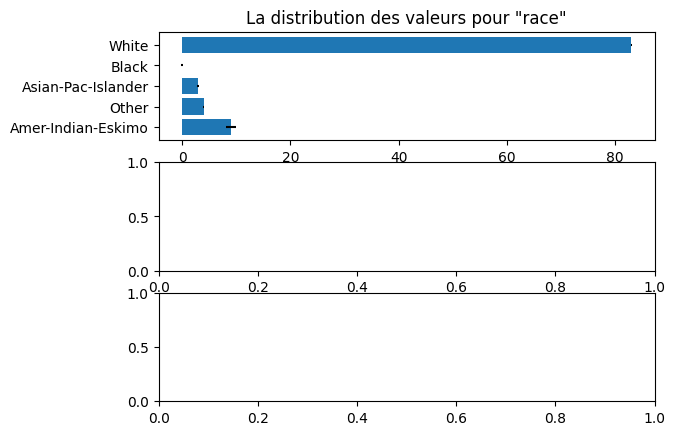

32561
[0.16577051972136422, 0.6772332992673373, 0.01300990694809105, 0.12871700221524573, 0.015269271847961657]
[0.5, 0.5, 0.5, 0.5, 0.5]

Client  1  groups distribution : 
White rate is :  17.0
Black rate is :  68.0
Asian-Pac-Islander rate is :  1.0
Other rate is :  13.0
Amer-Indian-Eskimo rate is :  2.0


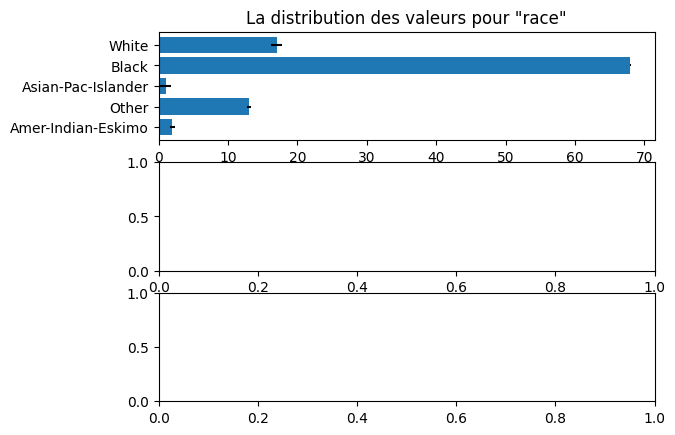

32561
[0.10279922226422526, 0.05648673414431388, 0.6868583524413733, 0.12731644716892887, 0.026539243981158655]
[0.5, 0.5, 0.5, 0.5, 0.5]

Client  2  groups distribution : 
White rate is :  10.0
Black rate is :  6.0
Asian-Pac-Islander rate is :  69.0
Other rate is :  13.0
Amer-Indian-Eskimo rate is :  3.0


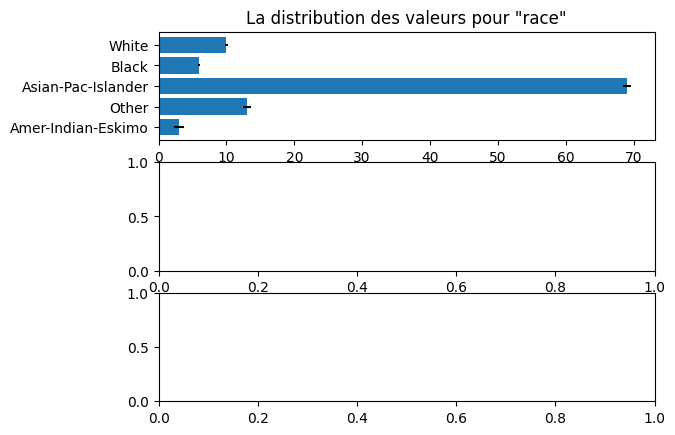

In [54]:

for i in range(n_clients):
    d_clients.append(Dirichelet_sampling(pre_processed_data, alphas['heterogeneous_2'], data[attribute_to_manipulate].unique(),client_dataset_size))
    print("\nClient ", i, " groups distribution : ")
    curr_client_distrib = check_balance(d_clients[i], attributes)
    if display:
        curr_client_distrib.show()

In [55]:
!pip install aif360 

In [56]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def rew(X_train,y_train_df):
        # Création des jeux de données d'entraînement et de test avec AIF360
        train_dataset = BinaryLabelDataset(df=X_train.join(y_train_df), label_names=['income'], 
                                           protected_attribute_names=['White', 'sex'], 
                                           favorable_label=1, unfavorable_label=0)
        # Définition des groupes privilégiés et non privilégiés
        privileged_groups = [{'White': 1}]  # Remplacez par vos propres valeurs
        unprivileged_groups = [{'White': 0}]  # Remplacez par vos propres valeurs

        # Application de la méthode de reweighing
        rw = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
        train_dataset_reweighed = rw.fit_transform(train_dataset)
        features_df = pd.DataFrame(train_dataset_reweighed.features, columns=train_dataset.feature_names)
        labels_df = pd.DataFrame(train_dataset_reweighed.labels, columns=['income'])

        return features_df, labels_df['income']
        
        

In [57]:
# def data_PreProcess_race(data):

#     nominal_features = ['race']

#     data = onehot_encode(data, nominal_features)
# #     normalized_data = (data - data.min()) / (data.max() - data.min())
#     # return pd.concat([normalized_x, y], axis=1)
#     return data

Epoch 1/2
356/356 [==============================] - 2s 3ms/step - loss: 3.1102 - accuracy: 0.7984 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0428 - val_accuracy: 0.8027 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
356/356 [==============================] - 1s 3ms/step - loss: 3.1102 - accuracy: 0.7984 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0428 - val_accuracy: 0.8027 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00


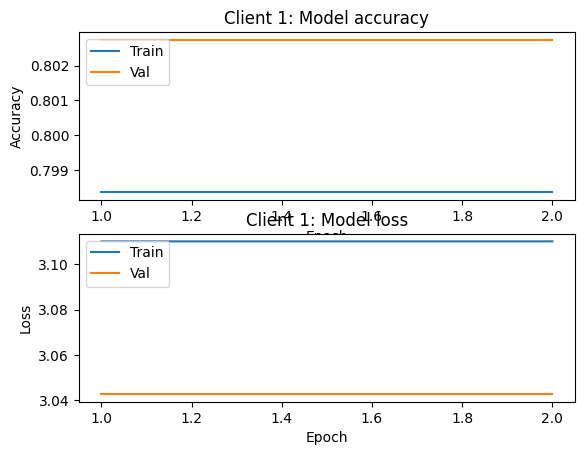

112/112 [==============================] - 0s 2ms/step - loss: 3.0971 - accuracy: 0.7992 - Precision: 0.0000e+00 - recall: 0.0000e+00


(Local) Fairness analysis : 
130/130 [==============================] - 0s 1ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
372/372 - 1s - loss: 3.7800 - accuracy: 0.7549 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 588ms/epoch - 2ms/step
372/372 [==============================] - 1s 1ms/step
Performance du modele sur le groupe (Black = 1)
2/2 - 0s - loss: 2.6697 - accuracy: 0.8269 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 29ms/epoch - 15ms/step
2/2 [==============================] - 0s 6ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
14/14 - 0s - loss: 3.7753 - accuracy: 0.7552 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 56ms/epoch - 4ms/st

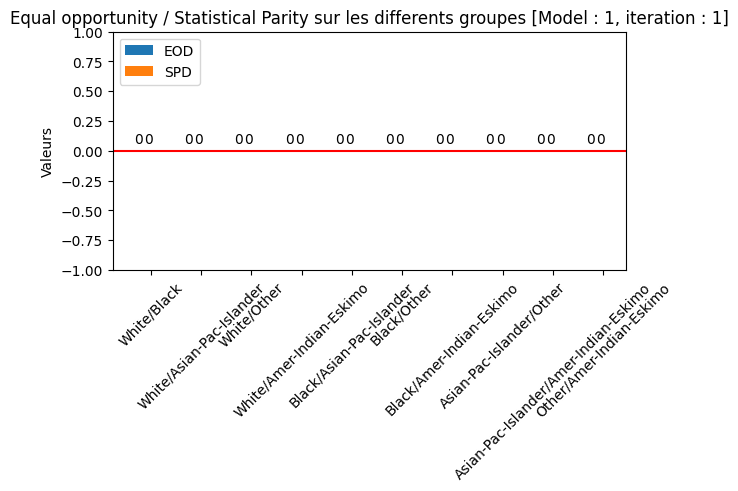

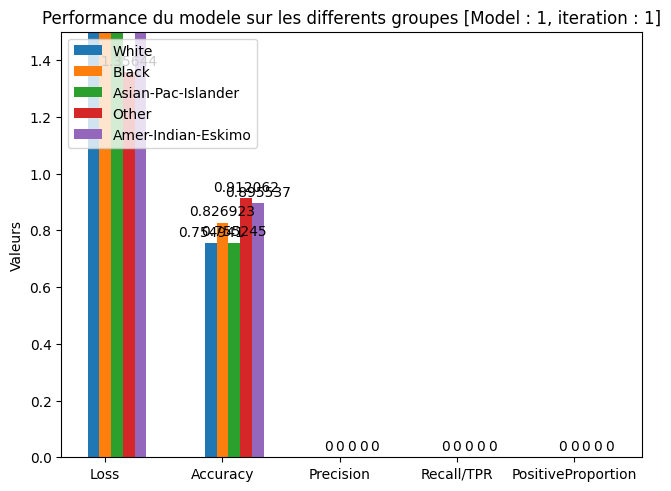

Epoch 1/2
721/721 [==============================] - 3s 3ms/step - loss: 0.5891 - accuracy: 0.7691 - Precision: 0.1391 - recall: 0.1599 - val_loss: 0.4814 - val_accuracy: 0.8527 - val_Precision: 0.2615 - val_recall: 0.1036
Epoch 2/2
721/721 [==============================] - 2s 2ms/step - loss: 0.4616 - accuracy: 0.8626 - Precision: 0.3183 - recall: 0.0777 - val_loss: 0.4512 - val_accuracy: 0.8816 - val_Precision: 0.6509 - val_recall: 0.0966


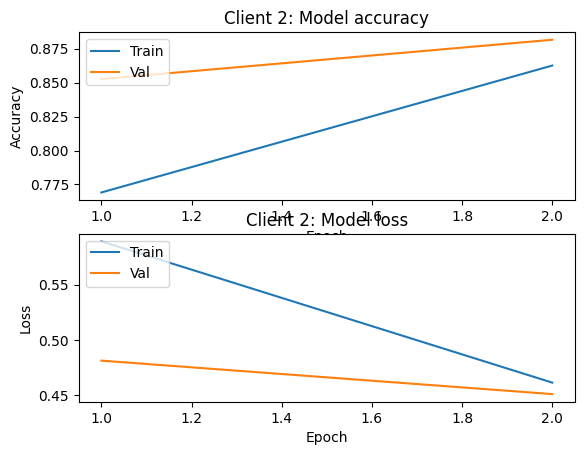

226/226 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.8802 - Precision: 0.6567 - recall: 0.0972


(Local) Fairness analysis : 
9/9 [==============================] - 0s 2ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
61/61 - 0s - loss: 0.6155 - accuracy: 0.7747 - Precision: 0.7383 - recall: 0.1626 - 115ms/epoch - 2ms/step
61/61 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Black = 1)
780/780 - 1s - loss: 0.4695 - accuracy: 0.8727 - Precision: 1.0000 - recall: 0.0094 - 1s/epoch - 1ms/step
780/780 [==============================] - 1s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
6/6 - 0s - loss: 0.7179 - accuracy: 0.7607 - Precision: 0.7143 - recall: 0.2222 - 52ms/epoch - 9ms/step
6/6 [=============================

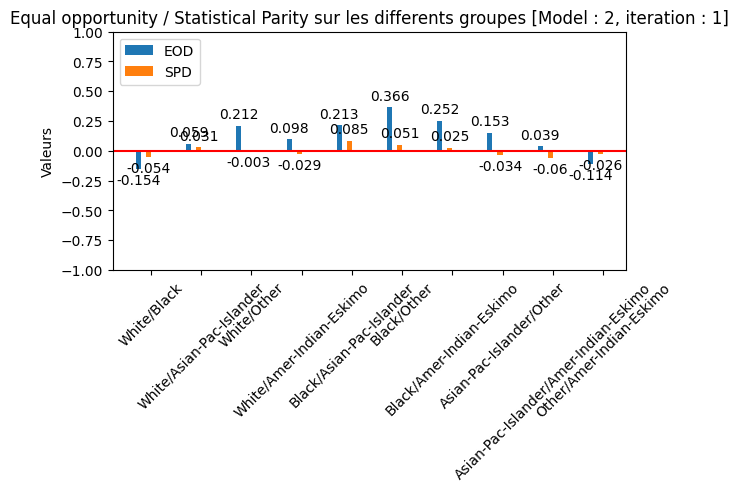

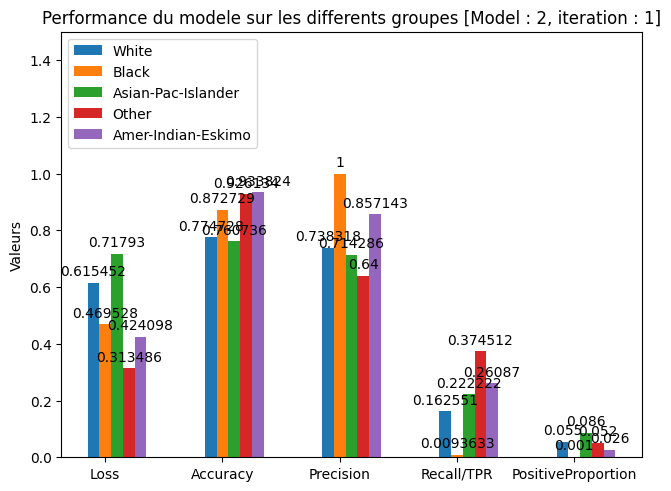

Epoch 1/2
1426/1426 [==============================] - 5s 3ms/step - loss: 0.7956 - accuracy: 0.7798 - Precision: 0.5269 - recall: 0.3056 - val_loss: 0.6073 - val_accuracy: 0.8053 - val_Precision: 0.5984 - val_recall: 0.3872
Epoch 2/2
1426/1426 [==============================] - 4s 3ms/step - loss: 0.5953 - accuracy: 0.8127 - Precision: 0.6230 - recall: 0.4455 - val_loss: 0.5567 - val_accuracy: 0.8280 - val_Precision: 0.6670 - val_recall: 0.4575


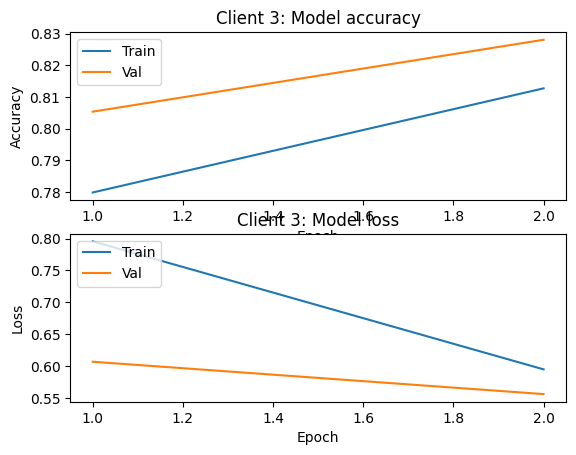

446/446 [==============================] - 1s 2ms/step - loss: 0.5688 - accuracy: 0.8238 - Precision: 0.6613 - recall: 0.4548


(Local) Fairness analysis : 
17/17 [==============================] - 0s 1ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
37/37 - 0s - loss: 0.8711 - accuracy: 0.7762 - Precision: 0.6279 - recall: 0.1908 - 85ms/epoch - 2ms/step
37/37 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Black = 1)
23/23 - 0s - loss: 0.4413 - accuracy: 0.8531 - Precision: 0.3605 - recall: 0.3690 - 67ms/epoch - 3ms/step
23/23 [==============================] - 0s 2ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
1889/1889 - 3s - loss: 0.5452 - accuracy: 0.8168 - Precision: 0.6701 - recall: 0.4864 - 3s/epoch - 1ms/step
1889/1889 [====================

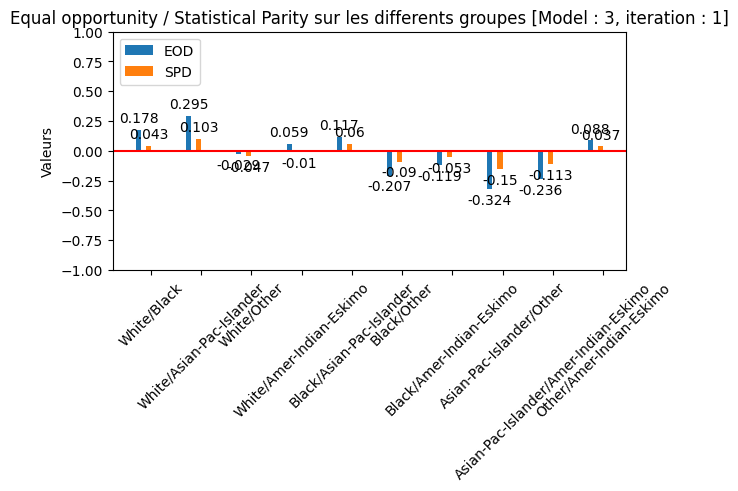

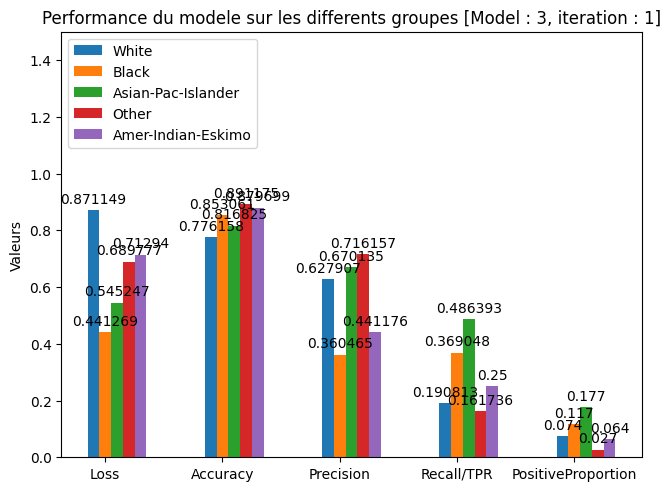

Global model [FedAvg] evaluation : 
1018/1018 - 2s - loss: 3.7145 - accuracy: 0.7592 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 2s/epoch - 2ms/step


(Gloal) Fairness analysis : 
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
870/870 - 1s - loss: 3.9466 - accuracy: 0.7441 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 1s/epoch - 1ms/step
870/870 [==============================] - 1s 1ms/step
Performance du modele sur le groupe (Black = 1)
98/98 - 0s - loss: 1.9108 - accuracy: 0.8761 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 167ms/epoch - 2ms/step
98/98 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
33/33 - 0s - loss: 4.0975 - accuracy: 0.7344 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 79ms/epoch - 2ms/step
33/33 [==========================

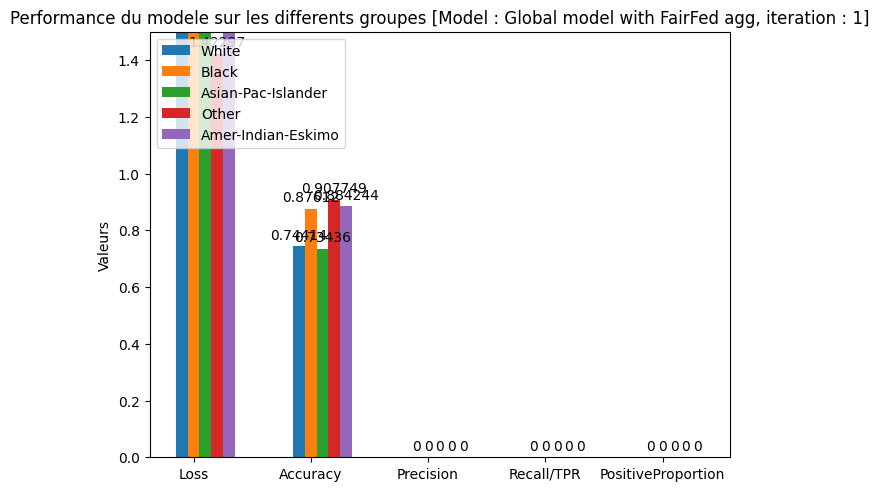

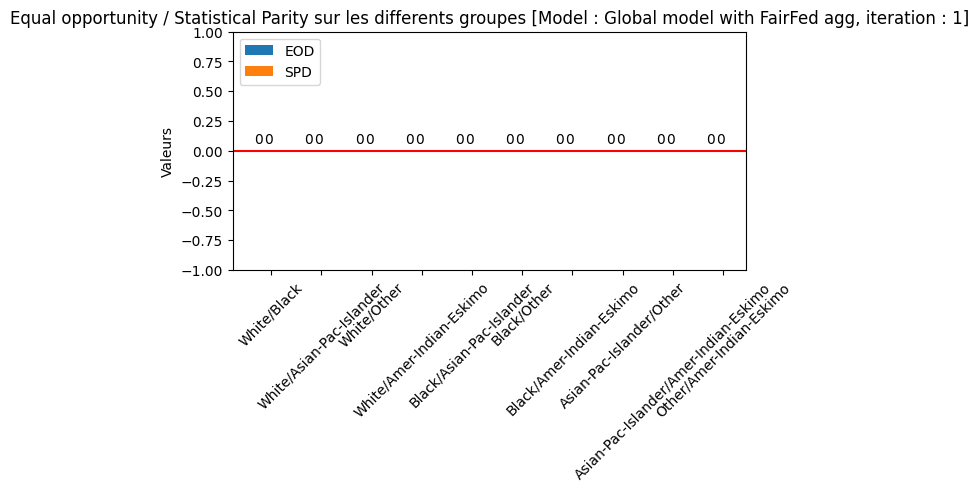

Epoch 1/2
356/356 [==============================] - 2s 3ms/step - loss: 3.1467 - accuracy: 0.7960 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8966 - val_accuracy: 0.8122 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
356/356 [==============================] - 1s 2ms/step - loss: 3.1467 - accuracy: 0.7960 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8966 - val_accuracy: 0.8122 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00


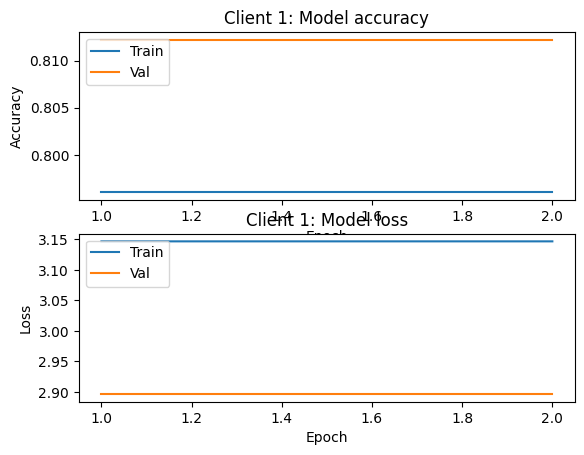

112/112 [==============================] - 0s 2ms/step - loss: 3.0971 - accuracy: 0.7992 - Precision: 0.0000e+00 - recall: 0.0000e+00


(Local) Fairness analysis : 
130/130 [==============================] - 0s 1ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
372/372 - 1s - loss: 3.7800 - accuracy: 0.7549 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 549ms/epoch - 1ms/step
372/372 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Black = 1)
2/2 - 0s - loss: 2.6697 - accuracy: 0.8269 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 30ms/epoch - 15ms/step
2/2 [==============================] - 0s 4ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
14/14 - 0s - loss: 3.7753 - accuracy: 0.7552 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 50ms/epoch - 4ms/st

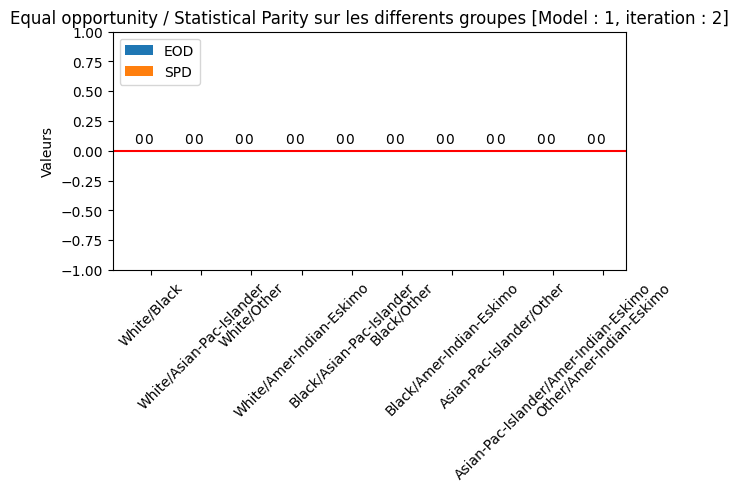

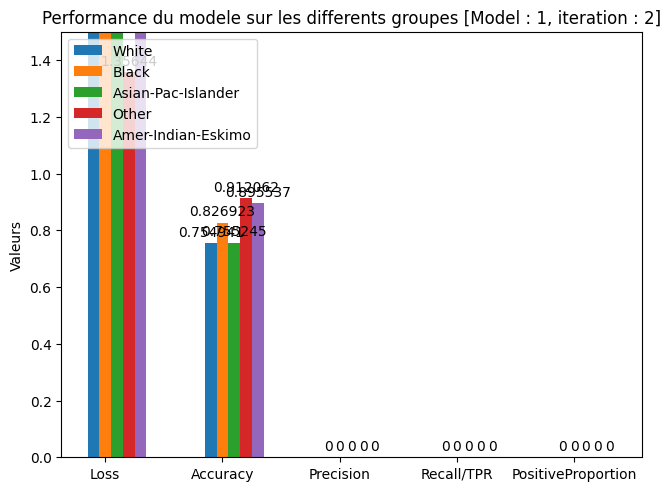

Epoch 1/2
721/721 [==============================] - 2s 3ms/step - loss: 1.9571 - accuracy: 0.8731 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8686 - val_accuracy: 0.8789 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
721/721 [==============================] - 2s 3ms/step - loss: 1.9571 - accuracy: 0.8731 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8686 - val_accuracy: 0.8789 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00


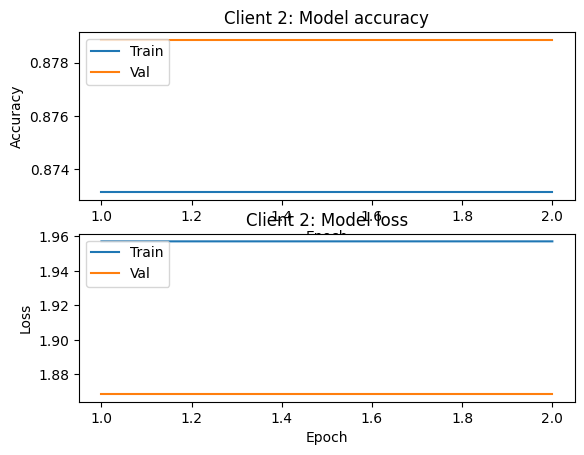

226/226 [==============================] - 0s 2ms/step - loss: 1.9383 - accuracy: 0.8743 - Precision: 0.0000e+00 - recall: 0.0000e+00


(Local) Fairness analysis : 
9/9 [==============================] - 0s 2ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
61/61 - 0s - loss: 3.8822 - accuracy: 0.7483 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 109ms/epoch - 2ms/step
61/61 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Black = 1)
780/780 - 1s - loss: 1.9817 - accuracy: 0.8715 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 1s/epoch - 1ms/step
780/780 [==============================] - 1s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
6/6 - 0s - loss: 4.2584 - accuracy: 0.7239 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 33ms/epoch - 5ms/step
6/

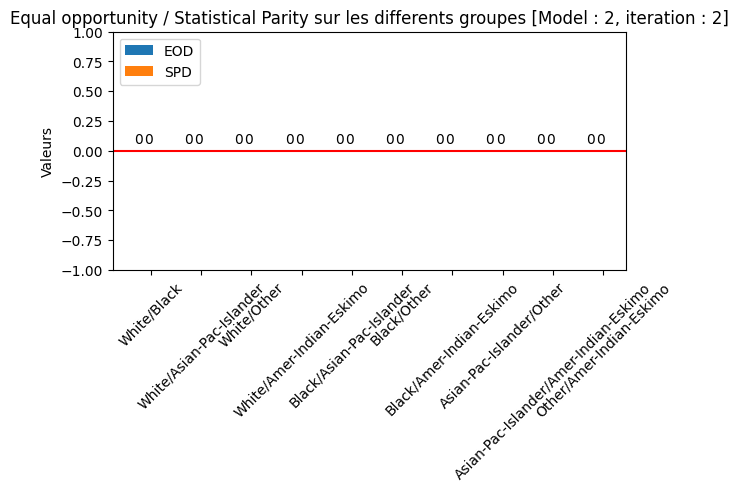

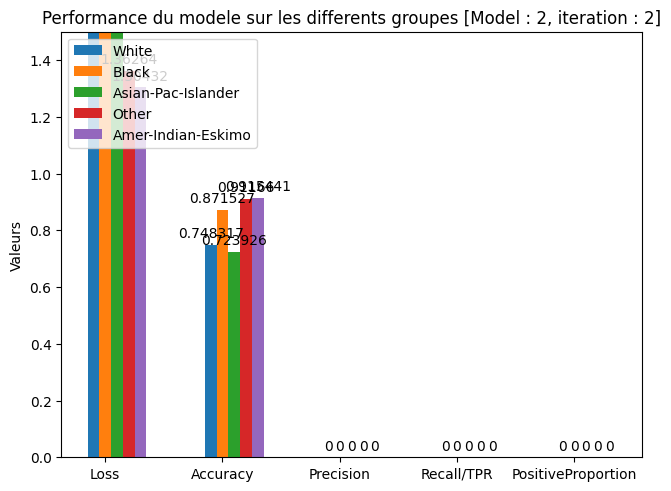

Epoch 1/2
1426/1426 [==============================] - 4s 3ms/step - loss: 3.5055 - accuracy: 0.7727 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.4440 - val_accuracy: 0.7767 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
1426/1426 [==============================] - 4s 3ms/step - loss: 3.5055 - accuracy: 0.7727 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.4440 - val_accuracy: 0.7767 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00


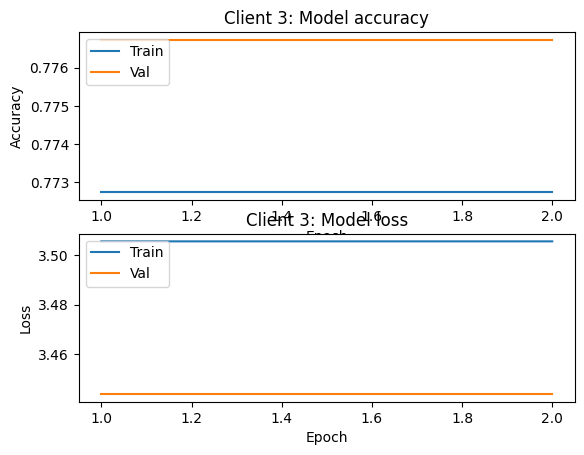

446/446 [==============================] - 1s 2ms/step - loss: 3.4934 - accuracy: 0.7735 - Precision: 0.0000e+00 - recall: 0.0000e+00


(Local) Fairness analysis : 
17/17 [==============================] - 0s 1ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
37/37 - 0s - loss: 3.7438 - accuracy: 0.7573 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 81ms/epoch - 2ms/step
37/37 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Black = 1)
23/23 - 0s - loss: 1.7629 - accuracy: 0.8857 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 59ms/epoch - 3ms/step
23/23 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
1889/1889 - 3s - loss: 3.7521 - accuracy: 0.7567 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 3s/epoch - 1ms/step

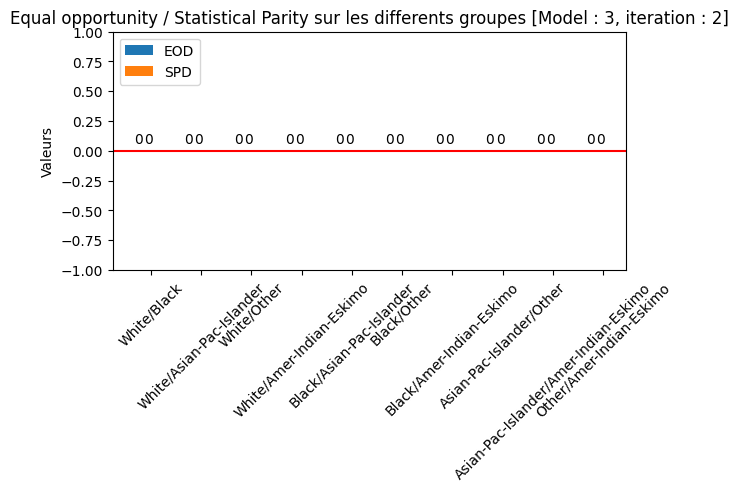

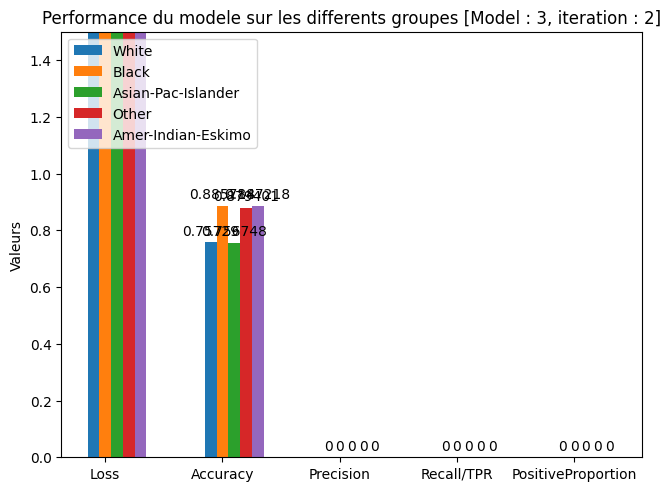

Global model [FedAvg] evaluation : 
1018/1018 - 2s - loss: 3.7145 - accuracy: 0.7592 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 2s/epoch - 2ms/step


(Gloal) Fairness analysis : 
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
870/870 - 1s - loss: 3.9466 - accuracy: 0.7441 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 1s/epoch - 1ms/step
870/870 [==============================] - 1s 1ms/step
Performance du modele sur le groupe (Black = 1)
98/98 - 0s - loss: 1.9108 - accuracy: 0.8761 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 167ms/epoch - 2ms/step
98/98 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
33/33 - 0s - loss: 4.0975 - accuracy: 0.7344 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 82ms/epoch - 2ms/step
33/33 [==========================

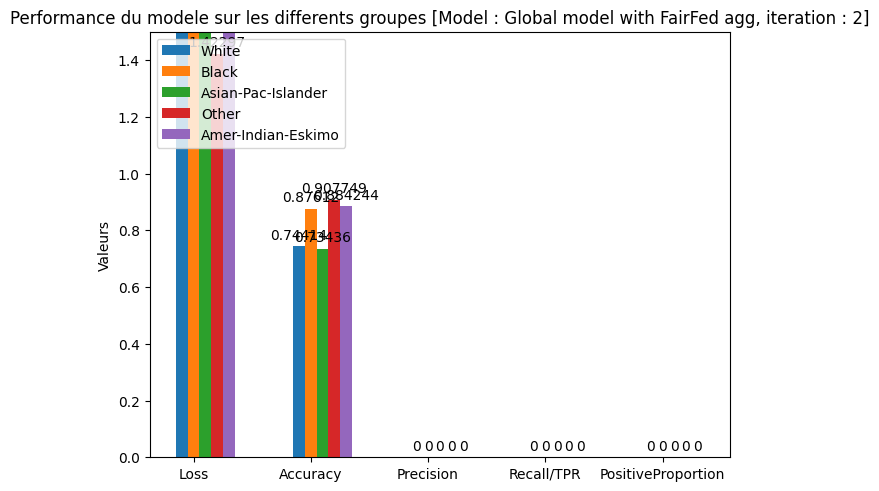

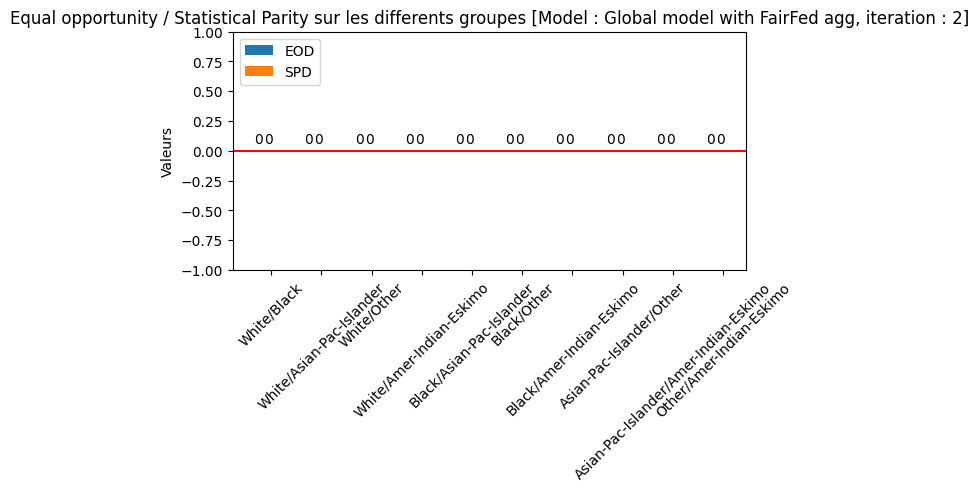

Epoch 1/2
356/356 [==============================] - 2s 3ms/step - loss: 3.1251 - accuracy: 0.7974 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.9832 - val_accuracy: 0.8066 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
356/356 [==============================] - 1s 3ms/step - loss: 3.1251 - accuracy: 0.7974 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.9832 - val_accuracy: 0.8066 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00


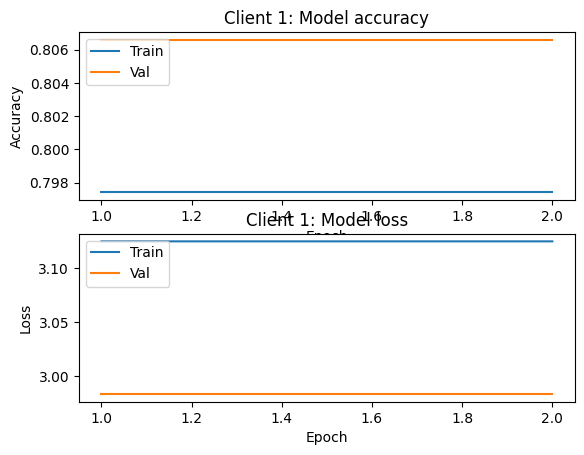

112/112 [==============================] - 0s 2ms/step - loss: 3.0971 - accuracy: 0.7992 - Precision: 0.0000e+00 - recall: 0.0000e+00


(Local) Fairness analysis : 
130/130 [==============================] - 0s 1ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
372/372 - 1s - loss: 3.7800 - accuracy: 0.7549 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 529ms/epoch - 1ms/step
372/372 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Black = 1)
2/2 - 0s - loss: 2.6697 - accuracy: 0.8269 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 29ms/epoch - 15ms/step
2/2 [==============================] - 0s 3ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
14/14 - 0s - loss: 3.7753 - accuracy: 0.7552 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 47ms/epoch - 3ms/st

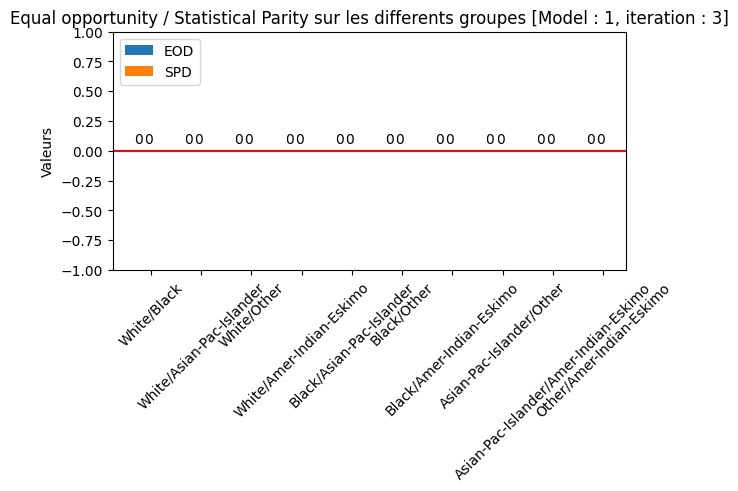

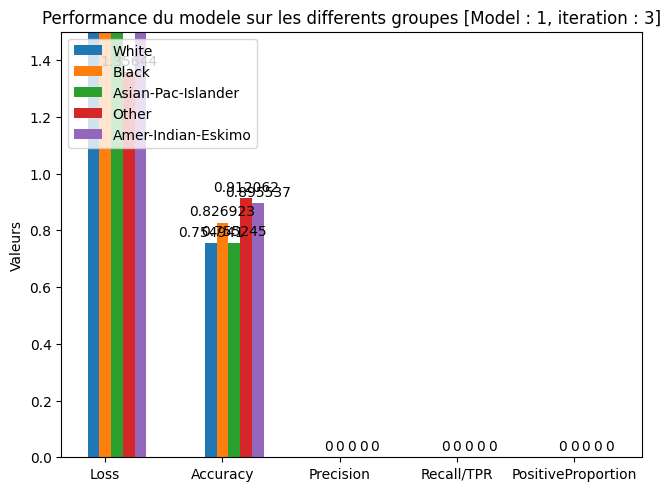

Epoch 1/2
721/721 [==============================] - 3s 3ms/step - loss: 1.9524 - accuracy: 0.8734 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8873 - val_accuracy: 0.8776 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
721/721 [==============================] - 2s 3ms/step - loss: 1.9524 - accuracy: 0.8734 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8873 - val_accuracy: 0.8776 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00


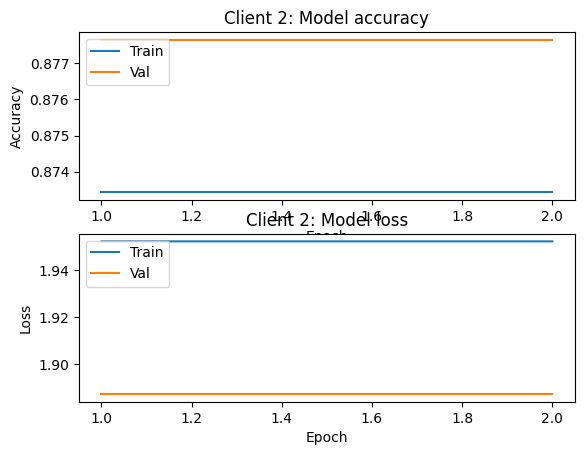

226/226 [==============================] - 0s 2ms/step - loss: 1.9383 - accuracy: 0.8743 - Precision: 0.0000e+00 - recall: 0.0000e+00


(Local) Fairness analysis : 
9/9 [==============================] - 0s 2ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
61/61 - 0s - loss: 3.8822 - accuracy: 0.7483 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 110ms/epoch - 2ms/step
61/61 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Black = 1)
780/780 - 1s - loss: 1.9817 - accuracy: 0.8715 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 1s/epoch - 2ms/step
780/780 [==============================] - 1s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
6/6 - 0s - loss: 4.2584 - accuracy: 0.7239 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 38ms/epoch - 6ms/step
6/

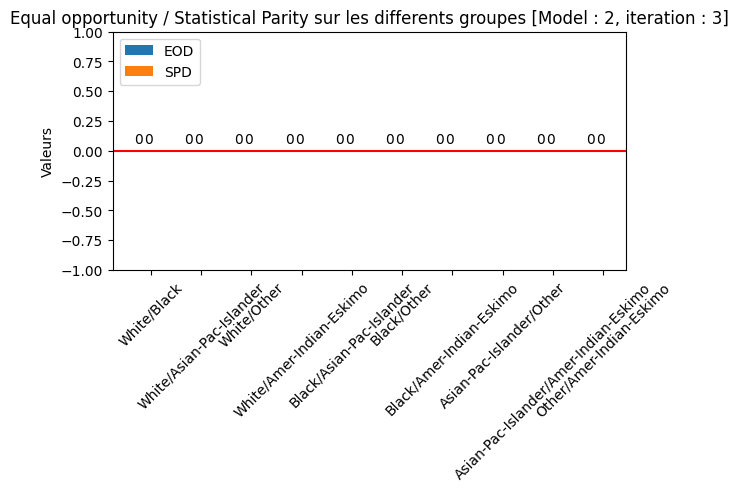

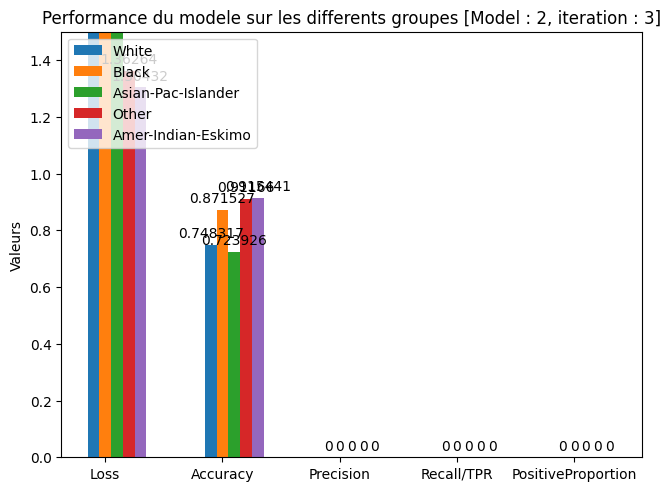

Epoch 1/2
1426/1426 [==============================] - 4s 3ms/step - loss: 3.4805 - accuracy: 0.7744 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.5441 - val_accuracy: 0.7702 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
1426/1426 [==============================] - 4s 3ms/step - loss: 3.4805 - accuracy: 0.7744 - Precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.5441 - val_accuracy: 0.7702 - val_Precision: 0.0000e+00 - val_recall: 0.0000e+00


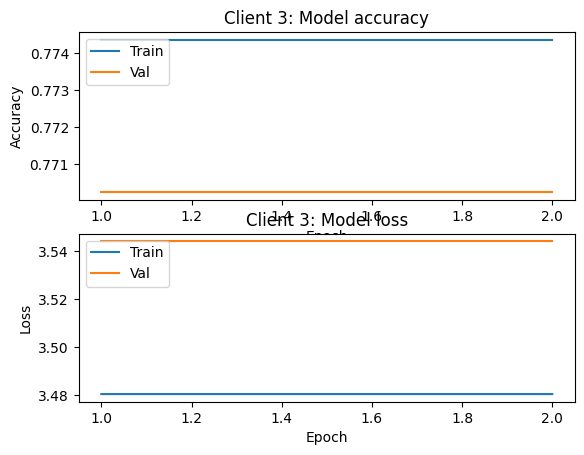

446/446 [==============================] - 1s 2ms/step - loss: 3.4934 - accuracy: 0.7735 - Precision: 0.0000e+00 - recall: 0.0000e+00


(Local) Fairness analysis : 
17/17 [==============================] - 0s 2ms/step
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
37/37 - 0s - loss: 3.7438 - accuracy: 0.7573 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 94ms/epoch - 3ms/step
37/37 [==============================] - 0s 2ms/step
Performance du modele sur le groupe (Black = 1)
23/23 - 0s - loss: 1.7629 - accuracy: 0.8857 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 65ms/epoch - 3ms/step
23/23 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
1889/1889 - 3s - loss: 3.7521 - accuracy: 0.7567 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 3s/epoch - 1ms/step

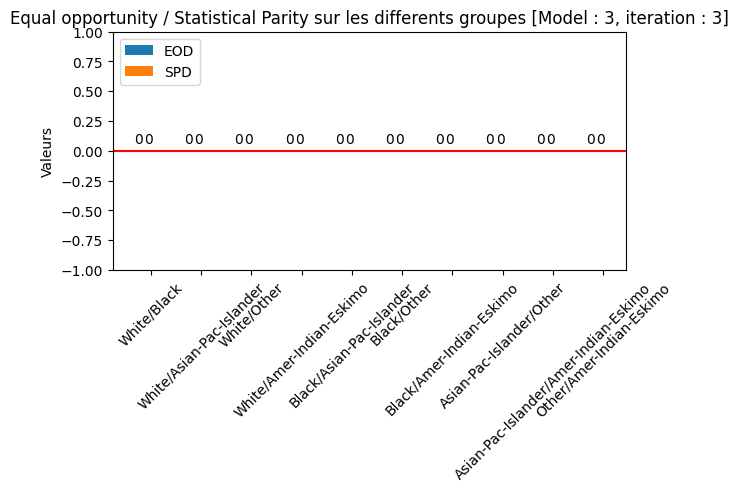

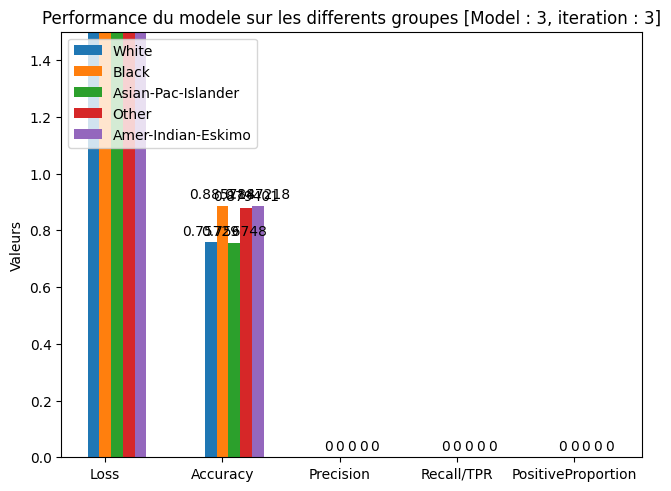

Global model [FedAvg] evaluation : 
1018/1018 - 2s - loss: 3.7145 - accuracy: 0.7592 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 2s/epoch - 2ms/step


(Gloal) Fairness analysis : 
evaluating for group :  White
evaluating for group :  Black
evaluating for group :  Asian-Pac-Islander
evaluating for group :  Other
evaluating for group :  Amer-Indian-Eskimo
Performance du modele sur le groupe (White = 1)
870/870 - 1s - loss: 3.9466 - accuracy: 0.7441 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 1s/epoch - 1ms/step
870/870 [==============================] - 1s 1ms/step
Performance du modele sur le groupe (Black = 1)
98/98 - 0s - loss: 1.9108 - accuracy: 0.8761 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 173ms/epoch - 2ms/step
98/98 [==============================] - 0s 1ms/step
Performance du modele sur le groupe (Asian-Pac-Islander = 1)
33/33 - 0s - loss: 4.0975 - accuracy: 0.7344 - Precision: 0.0000e+00 - recall: 0.0000e+00 - 85ms/epoch - 3ms/step
33/33 [==========================

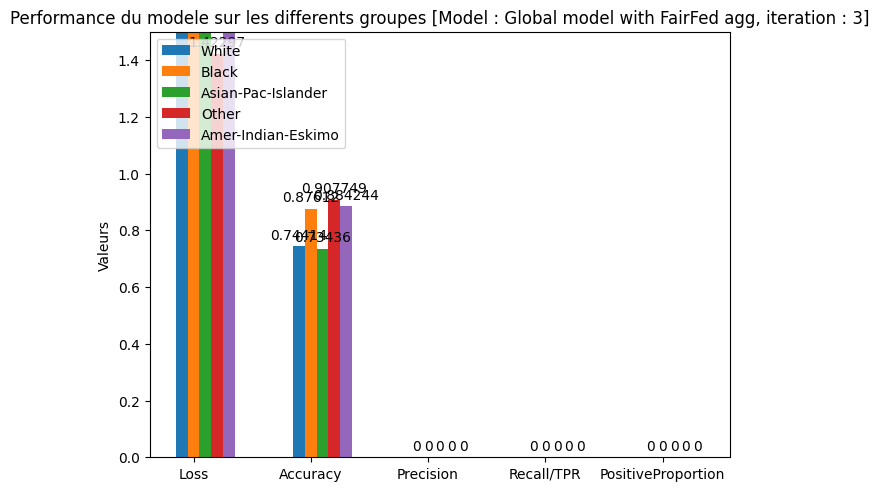

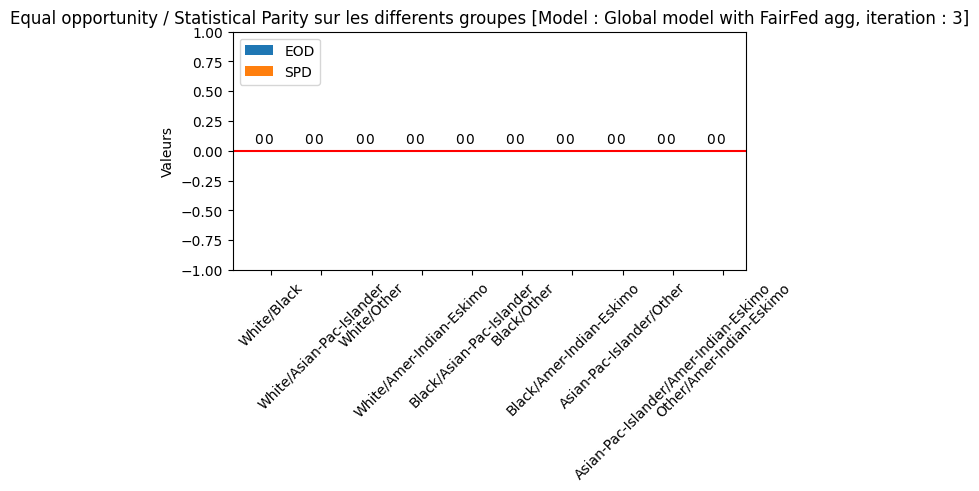

In [59]:
for j in range(learning_iterations):
    models = []
    metric_values = []
    mk_global_gr = []
    shape=()
    for i in range(len(d_clients)):
            # n_client = 1 apprentissage centralisé.
        if n_clients == 1:
            d_client = pre_processed_data

        y_client = d_clients[i]['income']
        x_client = d_clients[i].drop('income', axis=1)
        x_client,y_client= rew(x_client,y_client)
#         x_client = pre_processed_data(x_client)
        shape = (None, x_client.shape[1])

        if j == 0:
            models.append(train_from_model(Adult_NN(shape), x_client, y_client, epochs, i + 1))
        else:
            models.append(train_from_model(FedAvg_global_model, x_client, y_client, epochs, i + 1))

            # calcul de la métrique EOD pour les groupes White Black
        print("\n\n(Local) Fairness analysis : ")

        fairness_plot = plot_Fairness_Values(models[i], x_client, y_client, data[attribute_to_manipulate].unique(), str(i + 1), str(j + 1))
        group_plot = Eval_group_fairness(models[i], x_client, y_client, data[attribute_to_manipulate].unique(),str(i + 1), str(j + 1))
        if display:
             fairness_plot.show()

        if display:
             group_plot.show()
  # Agggregate pour vanilla FedAvg

    FedAvg_global_model = FedAvg(models, n_clients, clients_weights=[1 / n_clients for i in range(n_clients)], input_shape=shape)
        # tester le model global sur
    y = pre_processed_data['income']
    x = pre_processed_data.drop('income', axis=1)
    print("Global model [FedAvg] evaluation : ")
    FedAvg_global_model.evaluate(x, y, verbose=2)
    print("\n\n(Gloal) Fairness analysis : ")

    groups_plot1 = Eval_group_fairness(FedAvg_global_model, x, y, data[attribute_to_manipulate].unique(),
                                           'Global model with FairFed agg', str(j + 1))
    fairness_plot1 = plot_Fairness_Values(FedAvg_global_model, x, y, data[attribute_to_manipulate].unique(),
                                              'Global model with FairFed agg', str(j + 1))
    if display:
        groups_plot1.show()
    if display:
        fairness_plot1.show()

